In [2]:
%reload_ext autoreload
%autoreload 2
from spice_net import *
from helpers import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Prelim

### Building a toy netlist with diodes

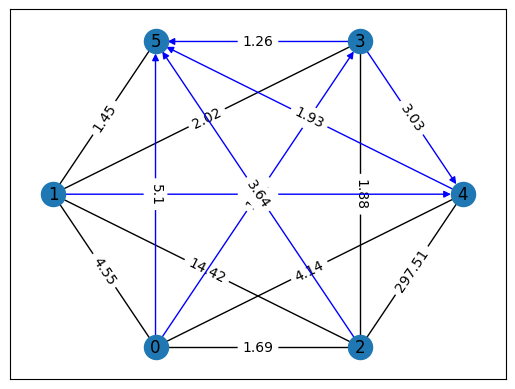

In [97]:
G = nx.erdos_renyi_graph(n=6, p=1)
thresh = 0.5
for u, v in G.edges():
    G[u][v]['weight'] = 1/np.random.rand()
    if np.random.rand() > thresh:
        G[u][v]['type'] = 'diode'
    else:
        G[u][v]['type'] = 'resistor'

vd = NonLinearNetwork('voltage_divider', con_graph=G, node_cfg=(np.array([]), np.array([])), epsilon=1e-16)
visualize(vd)

### Looking at inputs, outputs, and updates on toy dataset

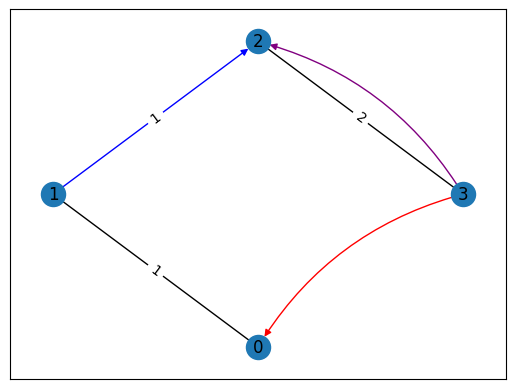

In [98]:
test_G = nx.Graph()
test_G.add_nodes_from(list(range(4)))
test_G.add_edge(0, 1, type='resistor', weight=1)
test_G.add_edge(1, 2, type='diode', weight=1)
test_G.add_edge(2, 3, type='resistor', weight=2)
test = NonLinearNetwork('test', test_G, node_cfg=([[0, 3]], [[2, 3]]))
visualize(test)

In [99]:
print(test)

.title test
.subckt e1 t_in t_out
R1 t_in dummy 1
D1 dummy t_out ReLu
.ends e1
B1 0 3
B2 2 3
Vindex index 0 1
R1 0 1 1
R2 2 3 2
X1 1 2 e1
.model ReLu D (js=0 n=0.001)



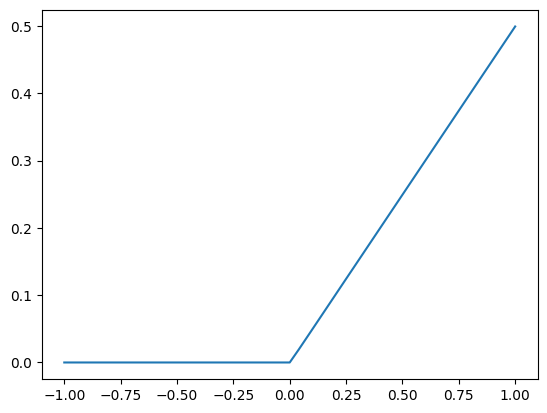

In [100]:
xs = np.linspace(-1, 1, 51)
plt.plot(xs, test.predict(xs[:, None]).squeeze())

### Handmade absolute value function example

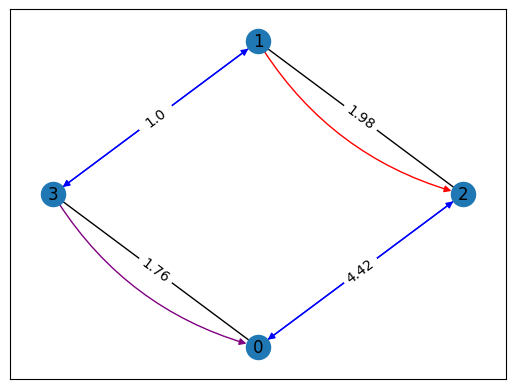

In [54]:
con_graph = nx.DiGraph()
con_graph.add_nodes_from(list(range(4)))

con_graph.add_edge(2, 1, type='resistor', weight=1./np.random.rand())
con_graph.add_edge(0, 3, type='resistor', weight=1./np.random.rand())

con_graph.add_edge(3, 1, type='diode', weight=1./np.random.rand())
con_graph.add_edge(2, 0, type='diode', weight=1./np.random.rand())
# con_graph.add_edge(1, 0, type='diode', weight=1./np.random.rand())
# con_graph.add_edge(3, 2, type='diode', weight=1./np.random.rand())
con_graph.add_edge(1, 3, type='diode', weight=1./np.random.rand())
con_graph.add_edge(0, 2, type='diode', weight=1./np.random.rand())

node_cfg = [[[2, 1]], [[0, 3]]]

handmade = NonLinearNetwork('handmade', con_graph, node_cfg)
visualize(handmade)

In [88]:
[tuple(map(int, R.node_names)) for R in handmade.edges]

[(0, 3), (1, 2)]

In [85]:
node_inds = np.transpose([tuple(map(int, R.node_names)) for R in handmade.edges])
node_inds

array([[0, 1],
       [3, 2]])

In [86]:
upd = np.random.randint(0, 10, size=(4, 4))
upd += upd.T
upd

array([[ 6,  9, 11,  6],
       [ 9, 16,  7,  7],
       [11,  7, 10,  6],
       [ 6,  7,  6,  2]])

In [87]:
upd[node_inds[0], node_inds[1]]

array([6, 7])

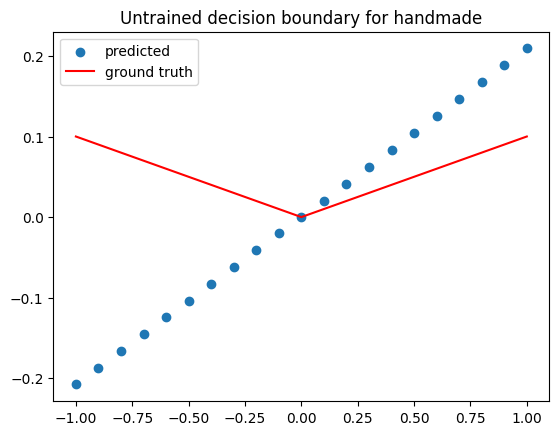

In [55]:
m = np.random.random()
m = .1
model = lambda x: np.abs(m*x)

lh = 1
num_pts = 21
xs = np.linspace(-lh, lh, num_pts)
ys = handmade.predict(xs[:, None]).squeeze()
# ys = [test_net.predict(x) for x in np.stack((np.linspace(0, lh, num_pts), np.ones(num_pts))).T]
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {handmade.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

In [56]:
# Train linear network
epochs = 30
trained_handmade, loss, updates, weights = train(handmade, xs[:,None], model(xs[:, None]), epochs, gamma=1, eta=0.1)

Epoch 1: 0.020440688494016673
Epoch 2: 0.017266154933205328
Epoch 3: 0.017415347283103528
Epoch 4: 0.0167623069896172
Epoch 5: 0.015320111070324488
Epoch 6: 0.01326332654944903
Epoch 7: 0.013362524243593962
Epoch 8: 0.011584997505383119
Epoch 9: 0.011461446783222645
Epoch 10: 0.011350632112355036
Epoch 11: 0.01035681947439743
Epoch 12: 0.009893971337680666
Epoch 13: 0.01039273527723886
Epoch 14: 0.01019064180250939
Epoch 15: 0.00922625533980782
Epoch 16: 0.009253983535741146
Epoch 17: 0.009331195507358088
Epoch 18: 0.008803855204475469
Epoch 19: 0.00910111695878235
Epoch 20: 0.009457784345490852
Epoch 21: 0.008477309657154973
Epoch 22: 0.009134140124288216
Epoch 23: 0.008605374350561374
Epoch 24: 0.008691148603808643
Epoch 25: 0.008125071128580163
Epoch 26: 0.008584582138999767
Epoch 27: 0.007924333171430856
Epoch 28: 0.008028958930388975
Epoch 29: 0.007660944435082059
Epoch 30: 0.008128795800762412


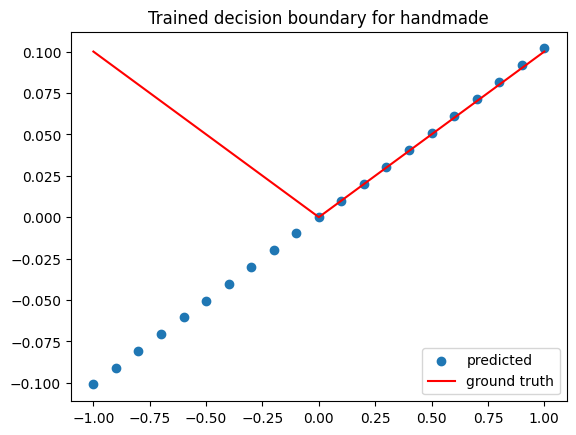

In [57]:
ys = trained_handmade.predict(xs[:, None])
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {handmade.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

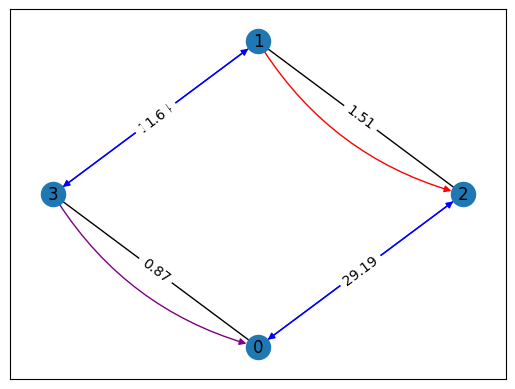

In [797]:
visualize(trained_handmade)

## Training on a nonlinear function

### Generate the dataset

In [3]:
# Generate N random points
N = 15
split = 1.
# pts = np.random.rand(N)
# pts = np.logspace(-2, 0, N)
pts = np.linspace(-1, 1, N)
sigma = 0.000

# Split into training and testing datasets
np.random.shuffle(pts)
training, test = {}, {}
training['x'], test['x'] = pts[:int(N*split), None], pts[int(N*split):, None]

# Generate noninear data
m = 0.1
b = 0

# model = (lambda m, b: lambda x: np.log(m*x + b)/100)(m, b) 
model = (lambda m, b: lambda x: np.abs(m*(x + b)))(m, b)

training['y'] = model(training['x']) + np.random.normal(0, sigma, training['x'].shape)
test['y'] = model(test['x']) + np.random.normal(0, sigma, test['x'].shape)

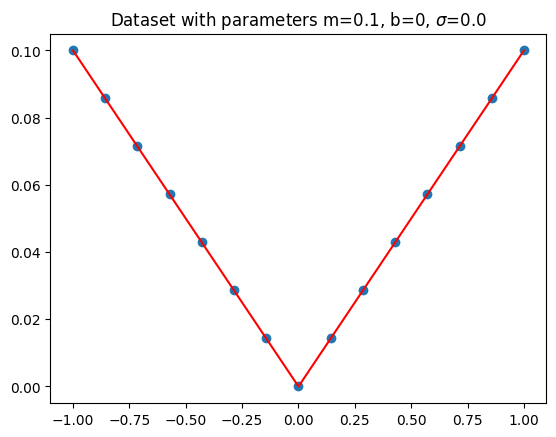

In [4]:
# Visualize dataset
plt.scatter(training['x'], training['y'])
plt.plot(np.sort(training['x'], axis=0), model(np.sort(training['x'], axis=0)), 'r',)
plt.title(fr'Dataset with parameters m={round(m, 3)}, b={round(b, 3)}, $\sigma$={sigma}')
plt.show()

### Nonlinear, no bias voltages

#### Generate random resistor + diode network

In [55]:
# Parameters
nodes = 40
avg_deg = 2
edge_prob =  avg_deg / nodes
diode_prob = .4

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=True)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        # if np.random.binomial(1, 0.5):
            # u, v = v, u
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = 1./np.random.rand() / nodes
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = 1./np.random.rand() / nodes
        res += 1

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

in_nodes = 1
out_nodes = 1
node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])
node_cfg

Num edges: 72
Num purely resistor: 44
Num diodes: 28


(array([[9, 2]]), array([[23, 17]]))

In [56]:
list(nx.isolates(con_graph))

[]

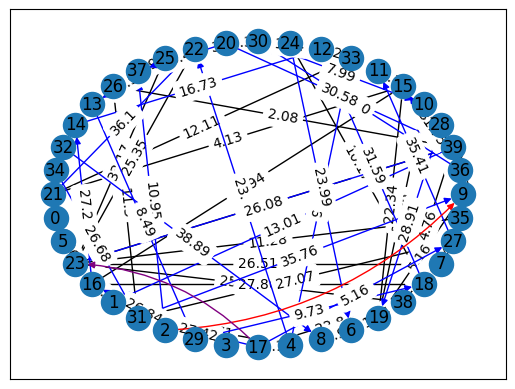

In [57]:
nonlin = NonLinearNetwork('nonlinear', con_graph, node_cfg)
visualize(nonlin, mode='y')

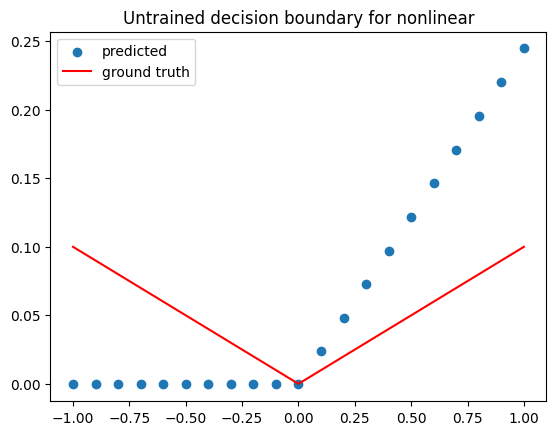

In [58]:
test_net = nonlin
lh = 1
num_pts = 21
xs = np.linspace(-lh, lh, num_pts)
ys = test_net.predict(xs[:, None])
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

#### Train network

In [59]:
# Train nonlinear network
epochs = 100

alpha = 1e-2
eta = 1e-2
gamma = alpha / eta / 2

trained_nonlin, loss, updates, weights = train(nonlin, training['x'], training['y'], epochs, gamma=gamma, eta=eta)

Epoch 1: 0.0059289492600546655
Epoch 2: 0.006211869736717089
Epoch 3: 0.006077175751750545
Epoch 4: 0.005938272394212737
Epoch 5: 0.006027236638425995
Epoch 6: 0.006044159462781416
Epoch 7: 0.006035942557861386
Epoch 8: 0.005948215861623878
Epoch 9: 0.005902409558559739
Epoch 10: 0.005703144046008054
Epoch 11: 0.005879634755522055
Epoch 12: 0.005691915674662858
Epoch 13: 0.005829393953171238
Epoch 14: 0.005842483861951288
Epoch 15: 0.0059787053162928495
Epoch 16: 0.005945835425265154
Epoch 17: 0.005766036676920814
Epoch 18: 0.00570009548114219


Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One successful gmin step
Trying gmin =   1.0000E-06 Note: One successful gmin step
Trying gmin =   1.0000E-07 Note: One successful gmin step
Trying gmin =   1.0000E-08 Note: One successful gmin step
Trying gmin =   1.0000E-09 Note: One successful gmin step
Trying gmin =   1.0000E-10 Note: One successful gmin step
Trying gmin =   1.0000E-11 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Note: Dynamic gmin stepping completed


NgSpiceCommandError: Command 'run' failed

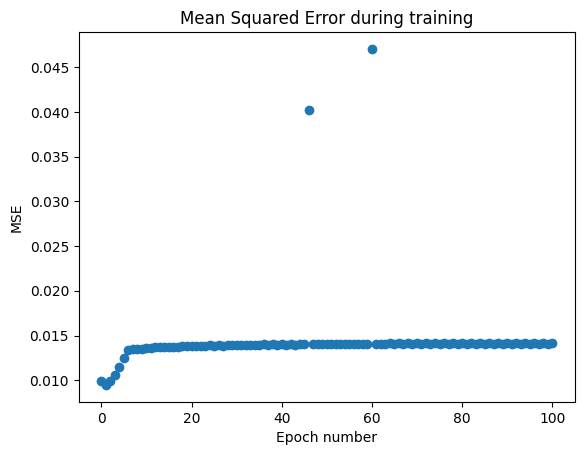

In [48]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

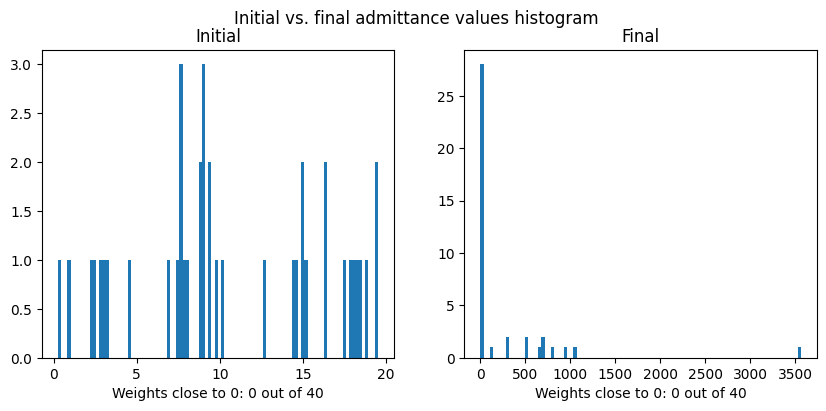

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(1./weights[0, -1], bins=100)
axs[0].set_title('Initial')
axs[0].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
axs[1].hist(1./weights[-1, -1], bins=100)
axs[1].set_title('Final')
axs[1].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
fig.suptitle('Initial vs. final admittance values histogram')
plt.show()

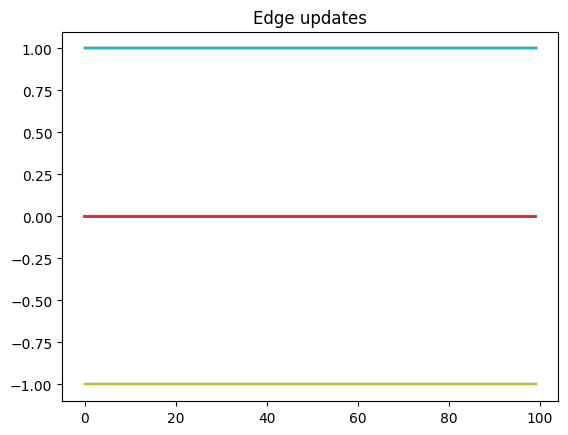

In [50]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
# plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

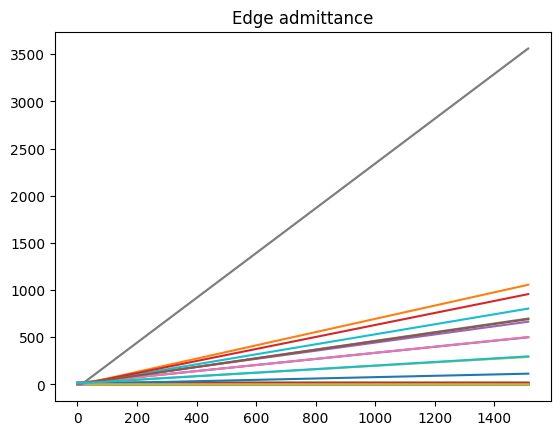

In [51]:
# plt.plot(1./weights.reshape(-1, weights.shape[-1]))
plt.plot(np.clip(1./weights.reshape(-1, weights.shape[-1]), -1, np.inf))
plt.title('Edge admittance')
plt.show()

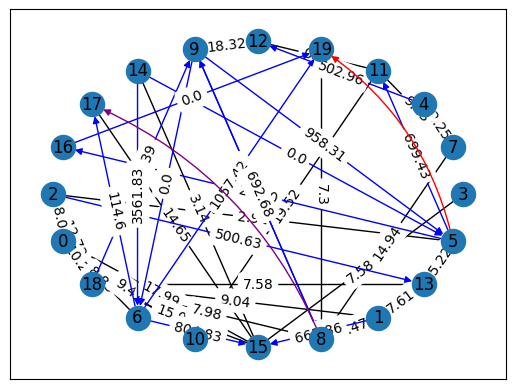

In [52]:
visualize(trained_nonlin, mode='y')

In [53]:
print(nonlin)

.title nonlinear
.subckt e1 t_in t_out
R1 t_in dummy 0.00150182541793019
D1 dummy t_out ReLu
.ends e1

.subckt e2 t_in t_out
R1 t_in dummy 0.0019974778637520396
D1 dummy t_out ReLu
.ends e2

.subckt e3 t_in t_out
R1 t_in dummy 0.0019882379914859596
D1 dummy t_out ReLu
.ends e3

.subckt e4 t_in t_out
R1 t_in dummy 0.0014297420488643632
D1 dummy t_out ReLu
.ends e4

.subckt e5 t_in t_out
R1 t_in dummy 0.003424664094371583
D1 dummy t_out ReLu
.ends e5

.subckt e6 t_in t_out
R1 t_in dummy 0.0012425013047381406
D1 dummy t_out ReLu
.ends e6

.subckt e7 t_in t_out
R1 t_in dummy 0.008725887120908464
D1 dummy t_out ReLu
.ends e7

.subckt e8 t_in t_out
R1 t_in dummy 0.0009456943630907204
D1 dummy t_out ReLu
.ends e8

.subckt e9 t_in t_out
R1 t_in dummy 999999999.9999999
D1 dummy t_out ReLu
.ends e9

.subckt e10 t_in t_out
R1 t_in dummy 0.0010435013278566666
D1 dummy t_out ReLu
.ends e10

.subckt e11 t_in t_out
R1 t_in dummy 999999999.9999999
D1 dummy t_out ReLu
.ends e11

.subckt e12 t_in t_out


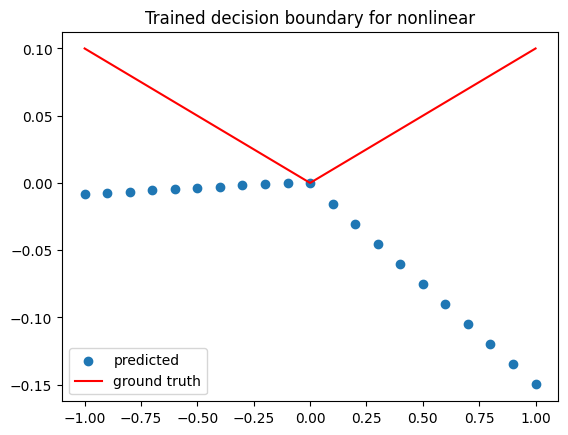

In [54]:
test_net = nonlin
ys = test_net.predict(xs[:, None])
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])

plt.show()

### Visualize training results over time

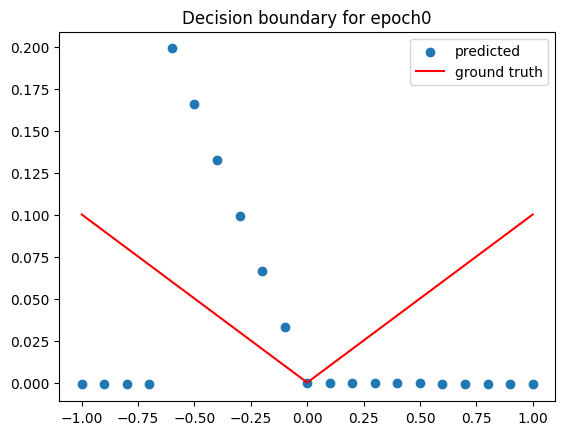

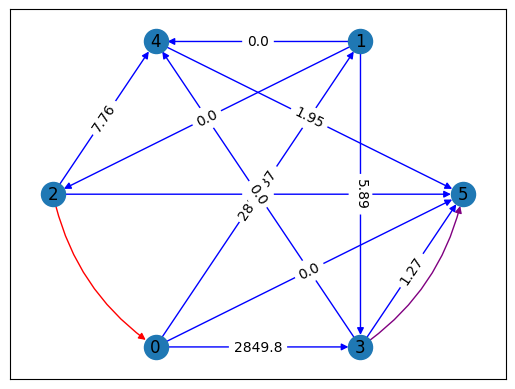

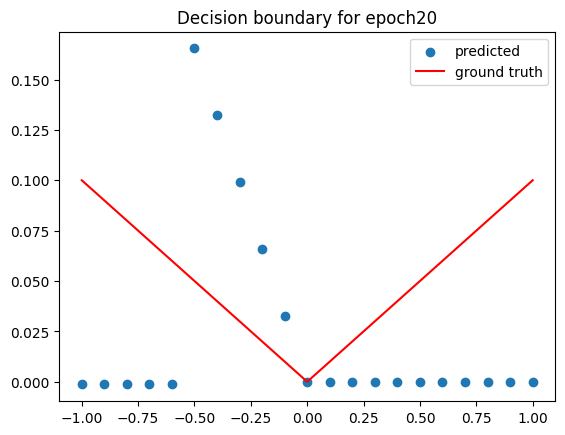

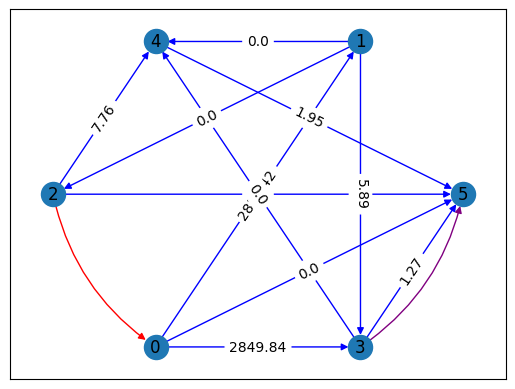

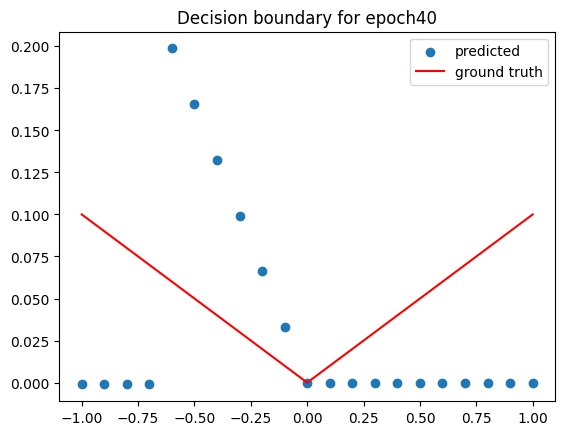

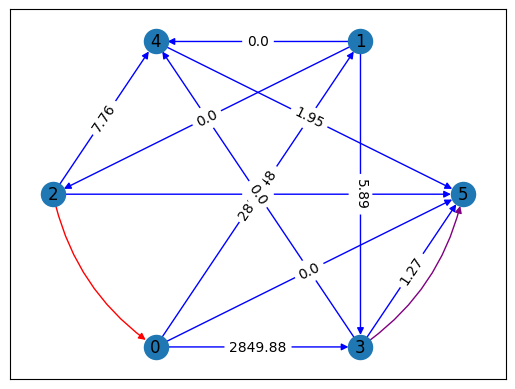

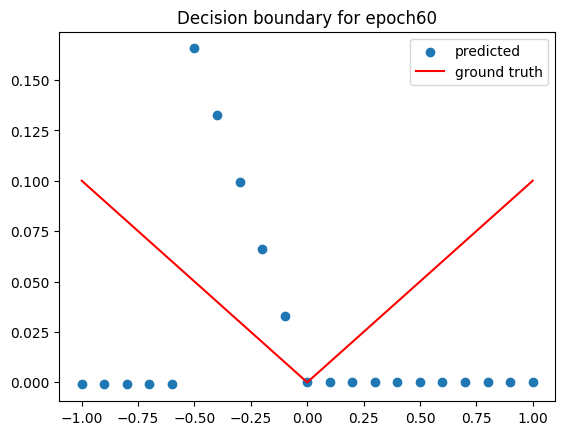

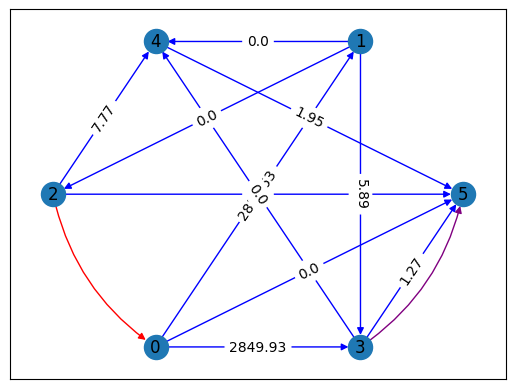

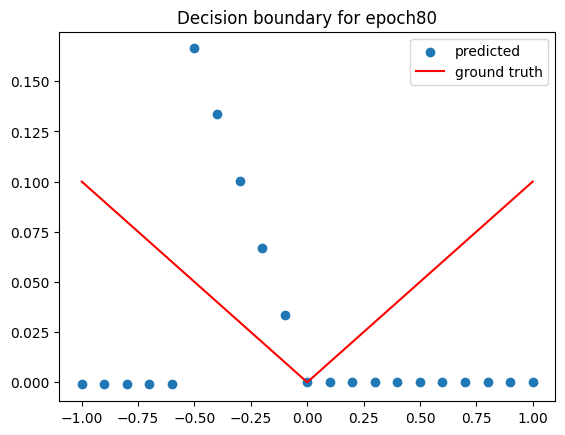

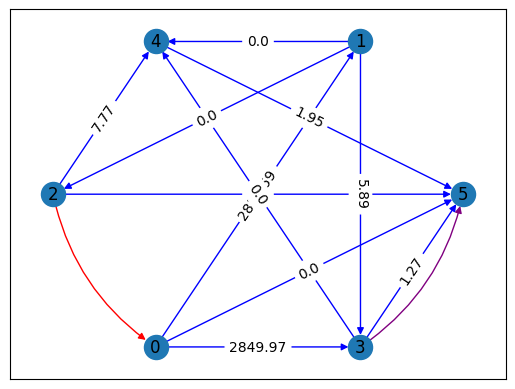

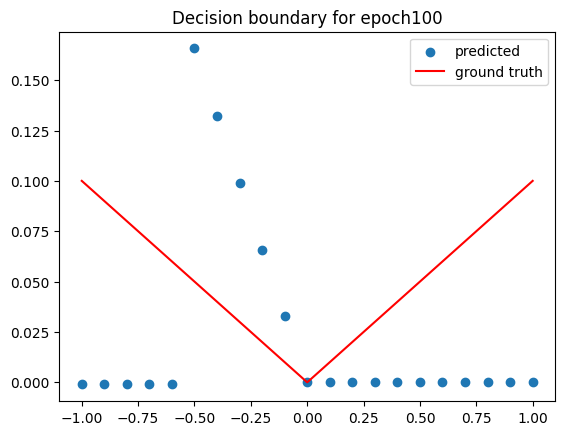

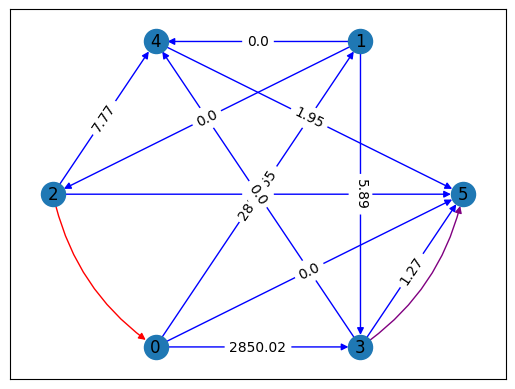

In [20]:
test_net: NonLinearNetwork = nonlin.copy(f'test_net')
for test_it in range(0, epochs+1, 20):
    for i, R in enumerate(test_net.edges):
        R.resistance = weights[test_it, 0][i]

    for i, X in enumerate(test_net.nonlinear_vals):
        X.R1.resistance = weights[test_it, 0][i + len(test_net.edges)]
    lh = 1
    num_pts = 21
    xs = np.linspace(-lh, lh, num_pts)
    # xs_bias = np.hstack((xs[:, None], np.tile(biases, (num_pts, 1))))


    ys = test_net.predict(xs[:,None])
    # ys = test_net.predict(xs_bias)

    plt.scatter(xs, ys)
    plt.plot(xs, model(xs), 'r')
    plt.title(f'Decision boundary for epoch{test_it}')
    plt.legend(['predicted', 'ground truth'])
    plt.show()
    visualize(test_net, mode='y')
    plt.show()

### Retry example with bias terms

In [1]:
# Parameters
nodes = 30
avg_deg = 2
edge_prob =  avg_deg / nodes
diode_prob = .8

# print('Num edges:', diodes + res)
# print('Num purely resistor:', res)
# print('Num diodes:', diodes)

in_nodes = 4
out_nodes = 1

con_graph = nx.erdos_renyi_graph(n=nodes, p=edge_prob, directed=True)
diodes, res = 0, 0
for u, v in con_graph.edges():
    if np.random.rand() < diode_prob:
        diodes += 1
        con_graph[u][v]['type'] = 'diode'
        con_graph[u][v]['weight'] = 1./np.random.rand() * nodes
    else:
        con_graph[u][v]['type'] = 'resistor'
        con_graph[u][v]['weight'] = 1./np.random.rand() * nodes
        res += 1

node_cfg = np.random.permutation([1]*in_nodes + [-1]*out_nodes + [0]*(nodes-in_nodes-out_nodes-1))
node_cfg = np.random.choice(nodes, size=(in_nodes + out_nodes, 2), replace=False)
node_cfg = (node_cfg[:in_nodes], node_cfg[in_nodes:])

print('Num edges:', diodes + res)
print('Num purely resistor:', res)
print('Num diodes:', diodes)

nonlin = NonLinearNetwork('nonlinear', con_graph, node_cfg)

NameError: name 'nx' is not defined

In [97]:
biases = np.random.normal(0, 1, size=in_nodes-1)

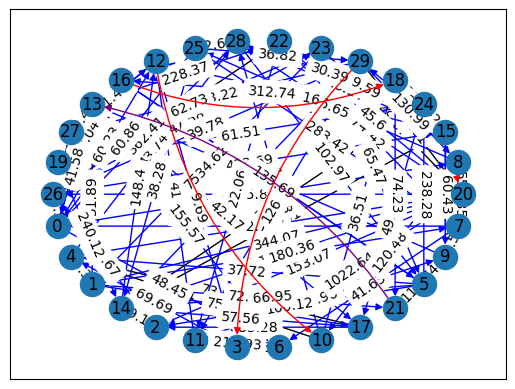

In [98]:
visualize(nonlin)

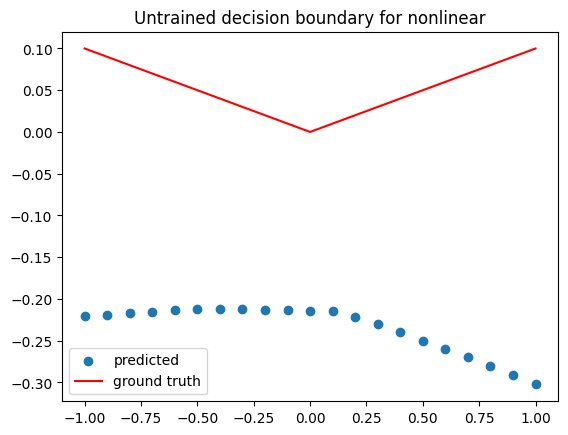

In [99]:
test_net = nonlin
lh = 1
num_pts = 21
xs = np.linspace(-lh, lh, num_pts)
ys = test_net.predict(np.hstack((xs[:, None], np.tile(biases, (num_pts, 1)))))
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Untrained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])
plt.show()

#### Train network

In [100]:
# Train nonlinear network
epochs = 100

alpha = 1e1
eta = 1e-2
gamma = alpha / eta / 2

training_bias = np.hstack((training['x'], np.ones((training['x'].shape[0], 3))))
trained_nonlin, loss, updates, weights = train(nonlin, training_bias, training['y'], epochs, gamma=gamma, eta=eta)

Epoch 1: 0.6032408512186316
Epoch 2: 0.5842904321199538
Epoch 3: 0.5933105824415396
Epoch 4: 0.5858237597690886
Epoch 5: 0.5936360746135242
Epoch 6: 0.5864740466615134


Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One successful gmin step
Trying gmin =   1.0000E-06 Note: One successful gmin step
Trying gmin =   1.0000E-07 Note: One successful gmin step
Trying gmin =   1.0000E-08 Note: One successful gmin step
Trying gmin =   1.0000E-09 Note: One successful gmin step
Trying gmin =   1.0000E-10 Note: One successful gmin step
Trying gmin =   1.0000E-11 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Note: Dynamic gmin stepping completed


NgSpiceCommandError: Command 'run' failed

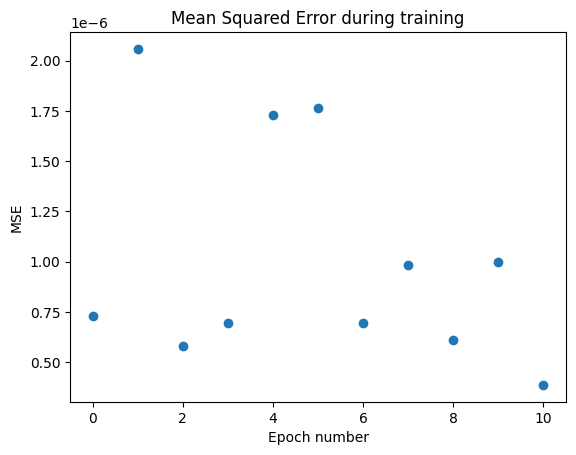

In [689]:
plt.scatter(np.arange(loss.size), loss)
plt.title('Mean Squared Error during training')
plt.xlabel('Epoch number')
plt.ylabel('MSE')
plt.show()

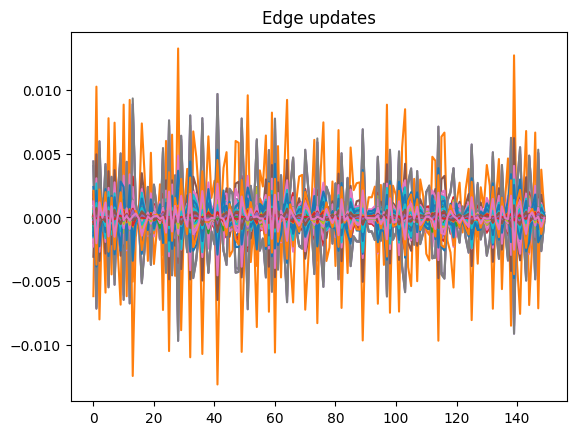

In [690]:
# plt.plot(updates.reshape(-1, updates.shape[-1]))
plt.plot(np.clip(updates.reshape(-1, updates.shape[-1]), -.5, .5))
# plt.plot(np.clip(updates.sum(axis=1), -1, 1))
plt.title('Edge updates')
plt.show()

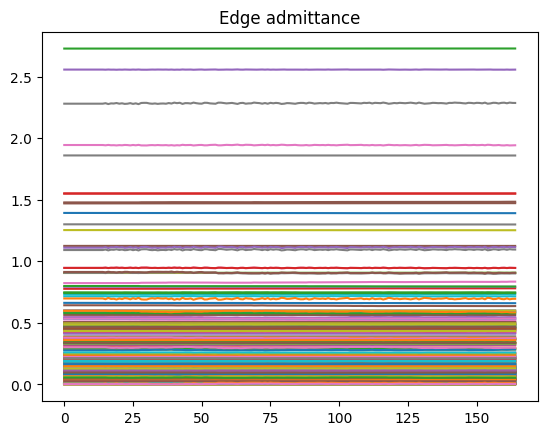

In [691]:
plt.plot(1./weights.reshape(-1, weights.shape[-1]))
# plt.plot(np.clip(1./weights, -np.inf, np.inf))
plt.title('Edge admittance')
plt.show()

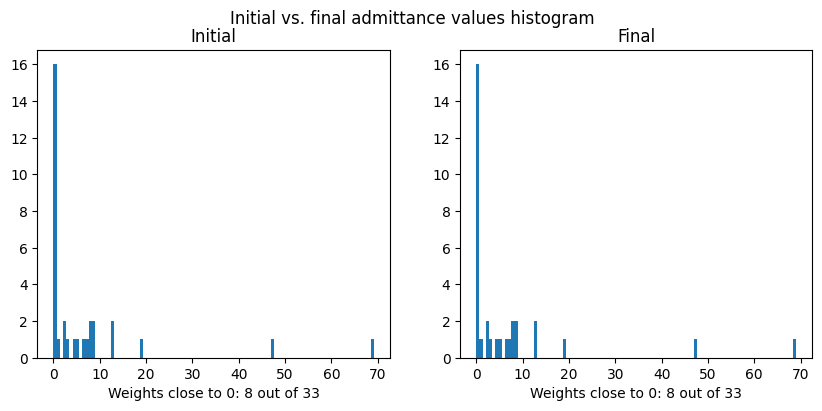

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(1./weights[0, -1], bins=100)
axs[0].set_title('Initial')
axs[0].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
axs[1].hist(1./weights[-1, -1], bins=100)
axs[1].set_title('Final')
axs[1].set_xlabel(f'Weights close to 0: {np.sum(np.isclose(weights[0, -1], 1./trained_nonlin.epsilon))} out of {weights[0, -1].size}')
fig.suptitle('Initial vs. final admittance values histogram')
plt.show()

In [693]:
# visualize(trained_nonlin, mode='y')

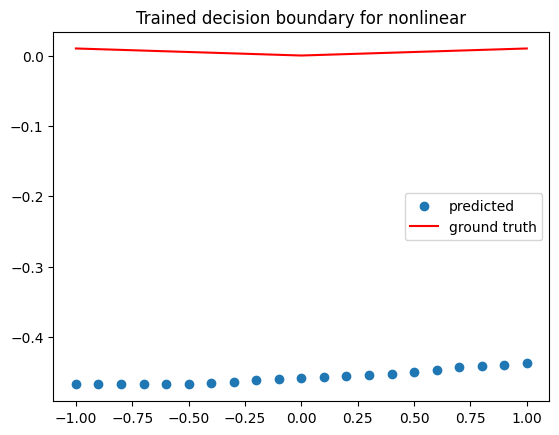

In [694]:
test_net = nonlin
ys = test_net.predict(np.hstack((xs[:, None], np.tile(biases, (num_pts, 1)))))
plt.scatter(xs, ys)
plt.plot(xs, model(xs), 'r')
plt.title(f'Trained decision boundary for {test_net.name}')
plt.legend(['predicted', 'ground truth'])

plt.show()